In [8]:
import torch
import torch.nn as nn
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, transforms
from torch.nn.functional import cross_entropy
from math import ceil
import random
import tqdm
from PIL import Image

In [9]:
train_data = FashionMNIST('.', download=True, train=True, transform=ToTensor())
val_data = FashionMNIST('.', download=True, train=False, transform=ToTensor())

In [10]:
print("len(train_data):", len(train_data))
print("len(val_data):", len(val_data))
print()
first_sample = train_data[0]
print("type(first_sample):", type(first_sample))
print("len(first_sample):", len(first_sample))
print("type(first_sample[0]):", type(first_sample[0]))
print("type(first_sample[1]):", type(first_sample[1]))
print()

image = first_sample[0]
label = first_sample[1]

print("Image size:", image.size)
print("Label:", label)

len(train_data): 60000
len(val_data): 10000

type(first_sample): <class 'tuple'>
len(first_sample): 2
type(first_sample[0]): <class 'torch.Tensor'>
type(first_sample[1]): <class 'int'>

Image size: <built-in method size of Tensor object at 0x15815d730>
Label: 9


In [11]:
image

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

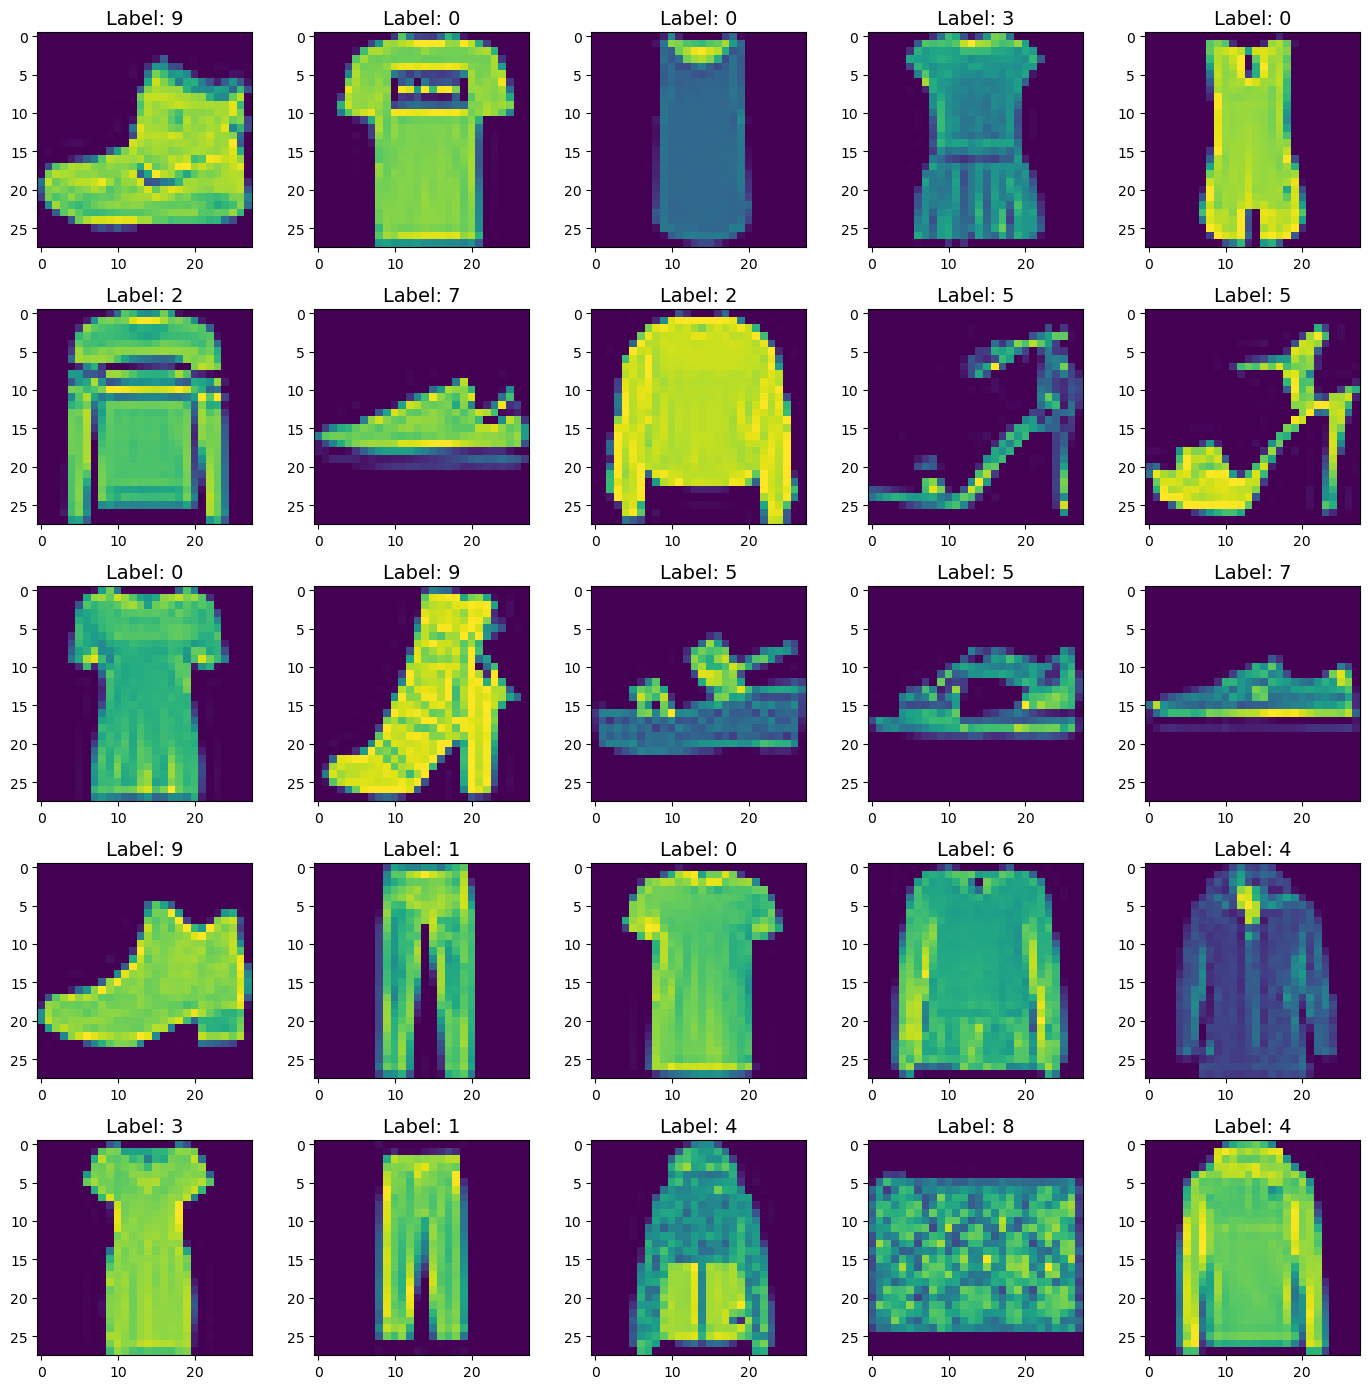

In [13]:
fig, axes = plt.subplots(5, 5, figsize=(14, 14))
for i in range(25):
    image, label = train_data[i]
    image = image.reshape(28, 28)
    ax = axes[i//5, i%5]
    ax.imshow(image)
    ax.set_title(f"Label: {label}", fontdict={"fontsize": 14})
plt.tight_layout()
plt.show()

In [14]:
class LeNet(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(LeNet, self).__init__()

        # first convolution layer + activation + max pooling
        self.conv1 = nn.Conv2d(input_shape[0], 20, (5, 5))
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        # second convolution layer + activation + max pooling
        self.conv2 = nn.Conv2d(20, 50, (5, 5))
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        # first linear layer + activation
        self.conv_output_len = (50 * 4 * 4)
        self.linear1 = nn.Linear(self.conv_output_len, 500)
        self.act3 = nn.ReLU()
        
        # final linear layer to produce the correct number of outputs
        self.linear2 = nn.Linear(500, num_classes)

    def forward(self, x):
        # perform convolution -> activation -> pooling
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        
        # flatten the features obtained from the conv layers: (BATCH_SIZE, 50, 4, 4) -> (BATCH_SIZE, 50*4*4)
        batch_size = x.shape[0]
        x = x.view(batch_size, self.conv_output_len)
        
        # final linear layers and activations
        x = self.act3(self.linear1(x))
        x = self.linear2(x)
        
        return x

In [15]:
NUM_EPOCHS = 100
BATCH_SIZE = 50
NUM_CLASSES = 10
LR = 0.001

train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

random.seed(0)
torch.manual_seed(0)
model = LeNet(NUM_CLASSES, (1, 28, 28))
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)



class MyTransform(object):
    def __init__(self, degrees):
        self.degrees = degrees
        self.to_tensor = transforms.ToTensor()

    def __call__(self, sample):
        random_angle = random.uniform(-self.degrees, self.degrees)
        
        if isinstance(sample, Image.Image):  
            pil_image = sample.convert('L')  
        else:  
            pil_image = transforms.ToPILImage()(sample).convert('L')  
        
        rotated_image = pil_image.rotate(random_angle) 
        tensor_image = self.to_tensor(rotated_image)  
        return tensor_image

rotation_degrees = 15
train_data.transform = MyTransform(rotation_degrees)
val_data.transform = MyTransform(rotation_degrees)


class CustomOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=0.001, weight_decay=0.001):
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super(CustomOptimizer, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for param in group['params']:
                if param.grad is None:
                    continue
                grad = param.grad
                param.data -= group['lr'] * grad - group['lr'] * group['weight_decay'] * param.data
                

optimizer = CustomOptimizer(model.parameters())

# Define the DataLoader function
def Loader(data, num_samples, transform, BATCH_SIZE=BATCH_SIZE):
    NUM_BATCHES = int(ceil(num_samples / BATCH_SIZE))
    
    for i in range(NUM_BATCHES):
        indices = range(i * BATCH_SIZE, min((i + 1) * BATCH_SIZE, num_samples))
        batch = [data[i] for i in indices]
        
        images = torch.stack([transform(item[0]) for item in batch])
        labels = torch.stack([torch.tensor(item[1]) for item in batch])
        yield images, labels

# Training loop
for epoch in range(NUM_EPOCHS):
    for mode, data, num_samples, transform in [
        ("train", train_data, len(train_data), train_data.transform),
        ("val", val_data, len(val_data), val_data.transform)
    ]:
        num_batches = int(ceil(num_samples / BATCH_SIZE))
        pbar = tqdm.tqdm(total=num_batches, desc=f"{mode} epoch {epoch}")

        if mode == "train":
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for i_batch, batch in enumerate(Loader(data, num_samples, transform)):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            predictions = model(images)
            loss = cross_entropy(predictions, labels)
            
            #l2_regularization
            l2_regularization = sum(torch.norm(param) ** 2 for param in model.parameters())
            loss += 0.001 * l2_regularization

            # Calculate accuracy and update metrics
            running_loss += loss.item() * len(images)
            correct_predictions += (torch.argmax(predictions, dim=-1) == labels).sum().item()
            total_samples += len(images)
            
            if mode == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Update progress bar
            pbar.update(1)
            pbar.set_postfix({
                "loss": running_loss / total_samples,
                "accuracy": correct_predictions / total_samples
            })

        # Calculate epoch loss and accuracy
        epoch_loss = running_loss / total_samples
        epoch_accuracy = correct_predictions / total_samples

        if mode == "train":
            train_losses.append(epoch_loss)
            train_accuracy.append(epoch_accuracy)
        else:
            val_losses.append(epoch_loss)
            val_accuracy.append(epoch_accuracy)

        pbar.close()


train epoch 0: 100%|█| 1200/1200 [00:25<00:00, 47.24it/s, loss=2.47, accuracy=0.
val epoch 0: 100%|█| 200/200 [00:01<00:00, 117.37it/s, loss=2.42, accuracy=0.216
train epoch 1: 100%|█| 1200/1200 [00:25<00:00, 46.70it/s, loss=2.27, accuracy=0.
val epoch 1: 100%|█| 200/200 [00:01<00:00, 111.85it/s, loss=1.95, accuracy=0.473
train epoch 2: 100%|█| 1200/1200 [00:25<00:00, 47.97it/s, loss=1.53, accuracy=0.
val epoch 2: 100%|█| 200/200 [00:01<00:00, 123.11it/s, loss=1.28, accuracy=0.632
train epoch 3: 100%|█| 1200/1200 [00:25<00:00, 46.73it/s, loss=1.19, accuracy=0.
val epoch 3: 100%|█| 200/200 [00:01<00:00, 113.03it/s, loss=1.14, accuracy=0.661
train epoch 4: 100%|█| 1200/1200 [00:25<00:00, 47.35it/s, loss=1.09, accuracy=0.
val epoch 4: 100%|█| 200/200 [00:01<00:00, 112.60it/s, loss=1.07, accuracy=0.689
train epoch 5: 100%|█| 1200/1200 [00:25<00:00, 47.50it/s, loss=1.05, accuracy=0.
val epoch 5: 100%|█| 200/200 [00:01<00:00, 107.62it/s, loss=1.03, accuracy=0.697
train epoch 6: 100%|█| 1200/

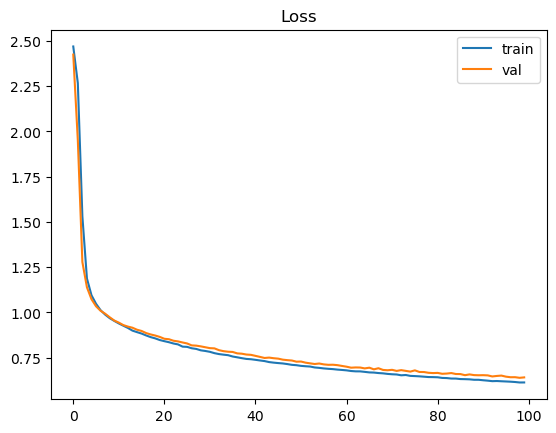

In [16]:
plt.title("Loss")
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()

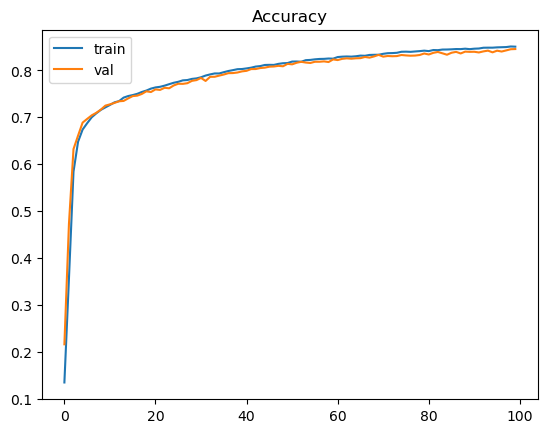

In [17]:
plt.title("Accuracy")
plt.plot(train_accuracy, label="train")
plt.plot(val_accuracy, label="val")
plt.legend()
plt.show()

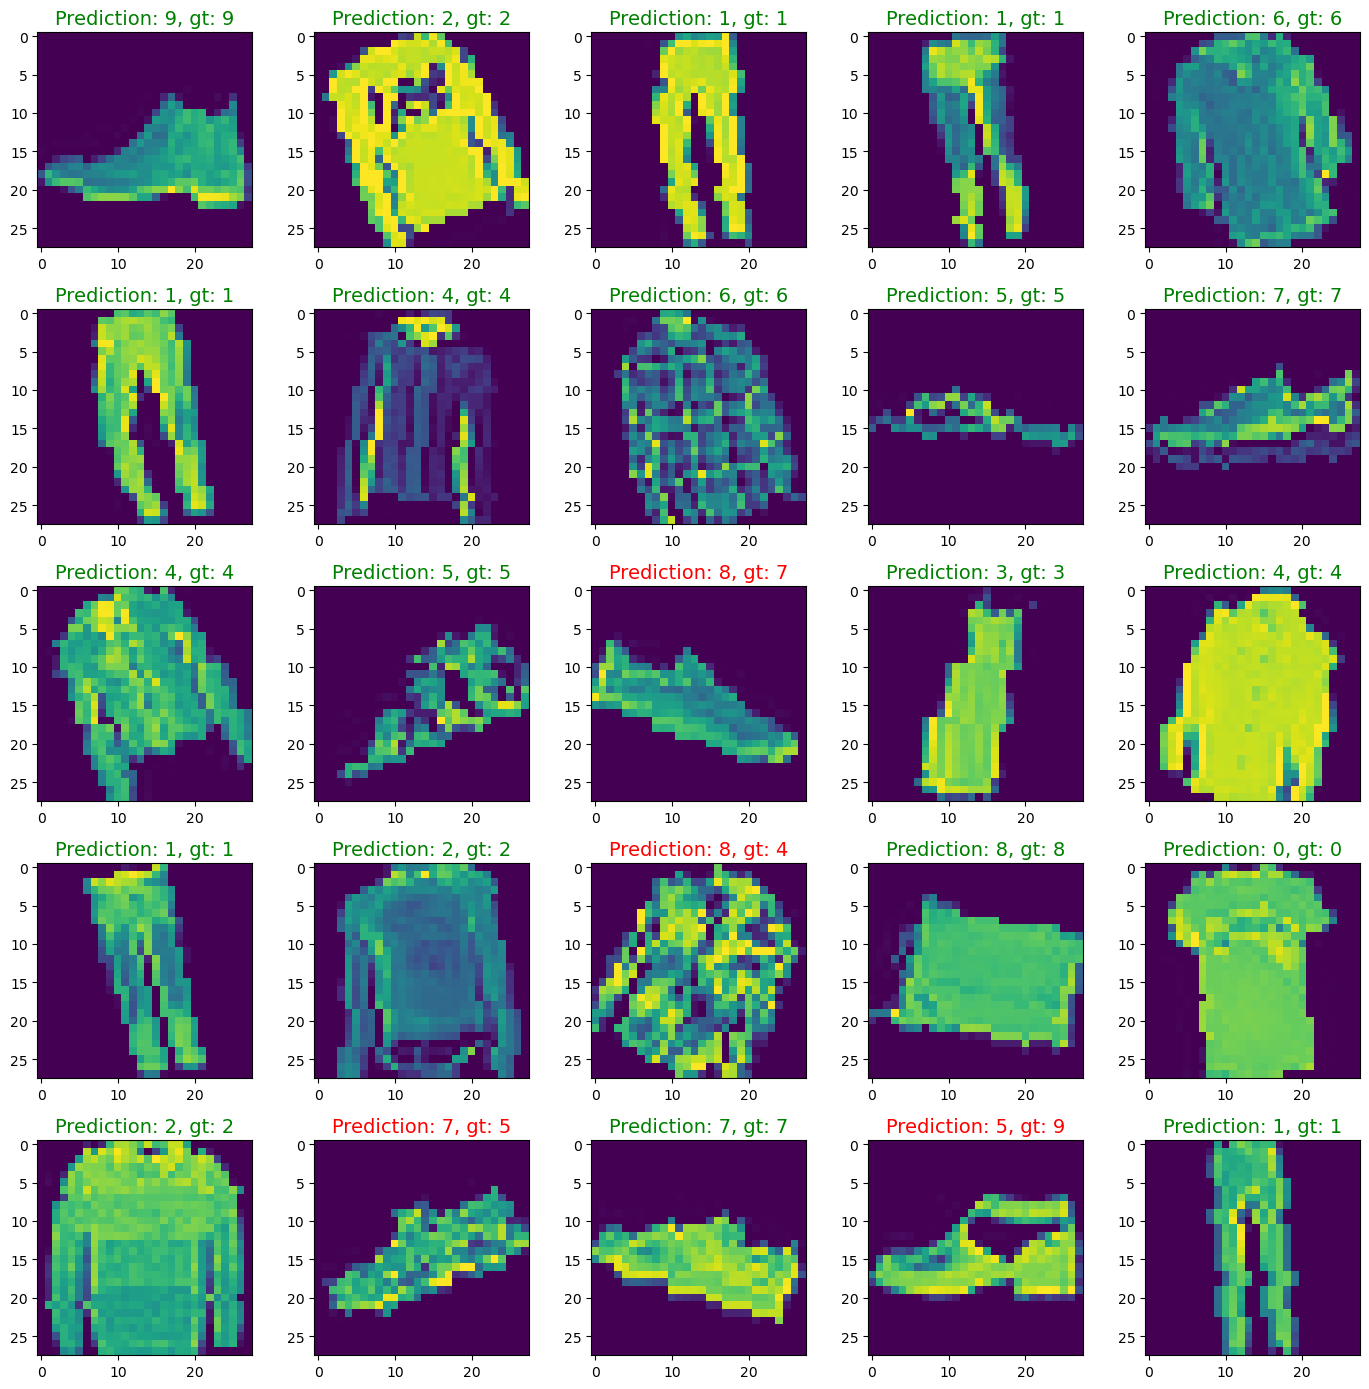

In [20]:
from torchvision.transforms.functional import to_pil_image

num_test_samples = 25
images, labels = next(Loader(val_data, num_test_samples, transform=val_data.transform, BATCH_SIZE=num_test_samples))

num_cols = 5
num_rows = int(ceil(num_test_samples/num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))

model.eval()
predictions = model(images.to(device))
scores = nn.functional.softmax(predictions, dim=-1)
predicted_classes = torch.argmax(scores, dim=-1)
# actually if we only need the index of the class with the highest probability, we could omit the softmax operation and perform argmax on the logits directly.
# predicted_classes = torch.argmax(predictions, dim=-1)

for i in range(num_test_samples):
    image, label = images[i], labels[i]
    predicted_class = predicted_classes[i].cpu().item()
    
    # convert the pytorch tensor back to a PIL image
    image = to_pil_image(image)
    
    ax = axes[i//num_cols, i%num_cols]
    ax.imshow(image)
    ax.set_title(f"Prediction: {predicted_class}, gt: {label}", fontdict={"fontsize": 14, "color": ("green" if predicted_class == label else "red")})
plt.tight_layout()
plt.show()